# ChurnLab: Baseline-Only Simulation with Influx

This notebook runs a standalone simulation using only the baseline heuristic strategy.  
It also enables user influx to test system scaling over long horizons.


In [1]:
# Imports and configuration
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from types import SimpleNamespace
from collections import defaultdict
from datetime import datetime, timedelta
from config import *
from config import rng
from numpy.random import default_rng
from population.PopulationBranch import PopulationBranch
from population.influx import compute_user_influx_rate
from population.user_generator import generate_single_user
from strategy.baseline_heuristics import compute_baseline_actions
from utils.constants import ARCHETYPES, RULES, STRATEGY_COSTS, TIER_ARR, FLAT_USER_HEALTH_DECAY, ROLLING_WINDOW

# Runtime config
runtime_config = SimpleNamespace(**globals())
runtime_config.DAYS = 180
runtime_config.BATCHES_PER_DAY = 6
runtime_config.TOTAL_BATCHES = runtime_config.DAYS * runtime_config.BATCHES_PER_DAY
runtime_config.NUM_USERS = 100
runtime_config.MAX_USERS = 250
rng = default_rng(42)


## Running the Baseline-Only Simulation

This block simulates user behavior using only the baseline heuristic strategy.

It runs for 180 days, with 6 batches per day, and enables user influx to simulate realistic population scaling.


In [2]:
# Initialize baseline-only user population
baseline = PopulationBranch(name="baseline")

# Storage for metrics
churn_curve = []
energy_usage = []
arr_retained = []
user_counts = []
archetype_tracker = defaultdict(int)

# Time tracking
start_ts = datetime.now()
batch_minutes = 24 * 60 // runtime_config.BATCHES_PER_DAY

for batch in range(runtime_config.TOTAL_BATCHES):
    ts = start_ts + timedelta(minutes=batch * batch_minutes)
    alive_uids = list(baseline.alive_users)
    batch_energy = 0
    batch_arr = 0
    batch_rows = []

    activity_window = {
        uid: list(baseline.user(uid)["activity"])[-ROLLING_WINDOW:]
        for uid in alive_uids
    }

    actions = compute_baseline_actions(
        batch_num=batch,
        alive_users=alive_uids,
        user_health={uid: baseline.user(uid)["user_health"] for uid in alive_uids},
        value={uid: baseline.user(uid)["value"] for uid in alive_uids},
        fatigue={uid: baseline.user(uid)["fatigue"] for uid in alive_uids},
        last_actions=baseline.last_actions,
        activity_window=activity_window
    )

    for uid in alive_uids:
        user = baseline.user(uid)
        action = actions.get(uid, "observe")
        rule = RULES.get((user["state"], action), {"next": user["state"], "d_health": 0, "penalty": 0})
        archetype = ARCHETYPES[user["archetype"]]

        log_mod = np.log1p(1 - user["user_health"])
        user["user_health"] = max(0.0, user["user_health"] + rule["d_health"] * archetype["user_health_mult"] * log_mod)
        user["user_health"] = max(0.0, user["user_health"] - FLAT_USER_HEALTH_DECAY)
        user["fatigue"] = min(runtime_config.MAX_FATIGUE, user["fatigue"] + rule["penalty"] * archetype["fatigue_mult"])
        user["state"] = rule["next"]

        batch_energy += STRATEGY_COSTS.get(action, 0.0)
        if user["user_health"] < 0.01:
            baseline.remove_user(uid)
        else:
            if user["user_health"] >= 0.2:
                batch_arr += TIER_ARR[user["value"]]
                archetype_tracker[user["archetype"]] += 1

    # Track metrics
    churn_curve.append(1 - len(baseline.alive_users) / runtime_config.NUM_USERS)
    energy_usage.append(batch_energy)
    arr_retained.append(batch_arr)
    user_counts.append(len(baseline.alive_users))

    # Apply influx logic
    if batch % runtime_config.BATCHES_PER_DAY == 0:
        influx_rate = compute_user_influx_rate(baseline.user_states)
        num_influx = int(influx_rate * len(baseline.user_states))
        for _ in range(num_influx):
            if len(baseline.user_states) >= runtime_config.MAX_USERS:
                break
            new_uid = max(baseline.user_states) + 1
            baseline.user_states[new_uid] = generate_single_user(new_uid)
            baseline.alive_users.add(new_uid)


## Visualizing Simulation Results

These charts summarize system-level dynamics over time using only the baseline strategy.


### Alive Users Over Time
This chart shows the total number of active users across simulation batches.
Notice the effect of churn and user influx on population size.


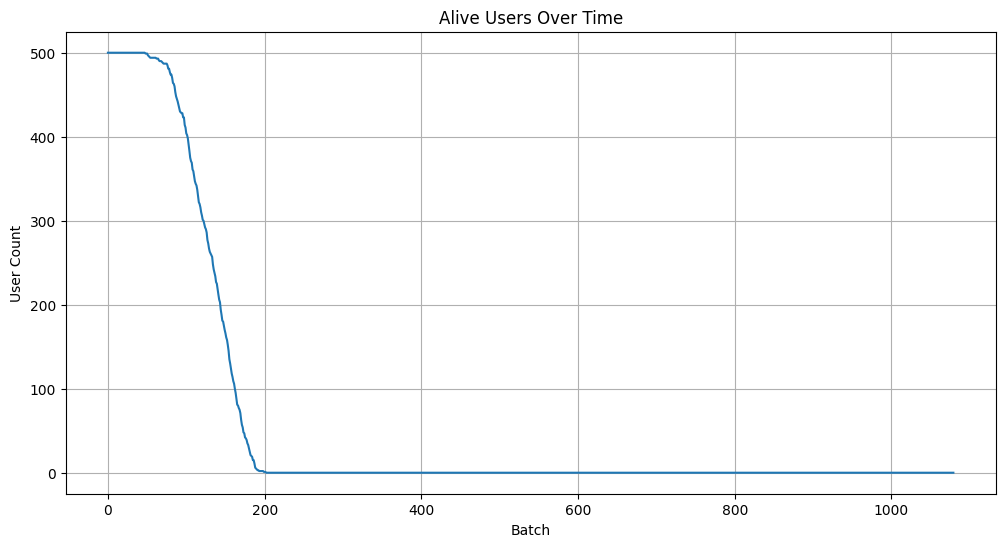

In [3]:
# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(user_counts)
plt.title("Alive Users Over Time")
plt.xlabel("Batch")
plt.ylabel("User Count")
plt.grid(True)
plt.show()

### Churn Curve
Displays the cumulative churn rate over time.
Useful for identifying stabilization or decay trends.


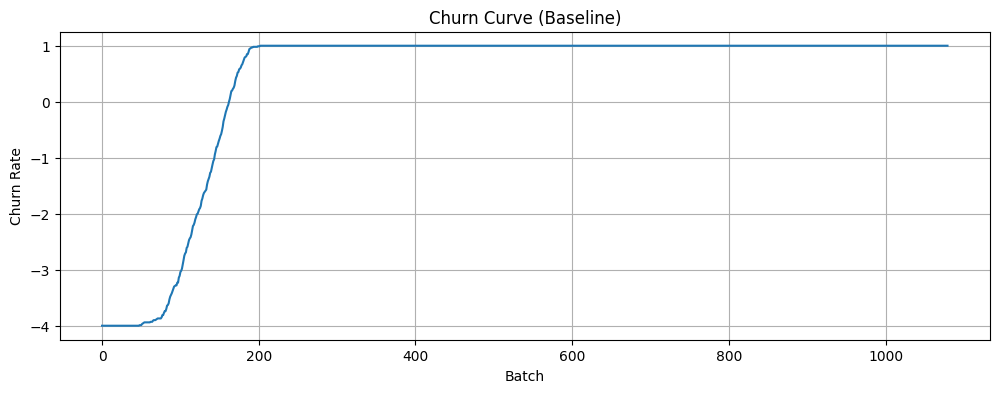

In [4]:

plt.figure(figsize=(12, 4))
plt.plot(churn_curve)
plt.title("Churn Curve (Baseline)")
plt.xlabel("Batch")
plt.ylabel("Churn Rate")
plt.grid(True)
plt.show()


### Energy Usage
Total strategy energy expended by the baseline heuristic per batch.

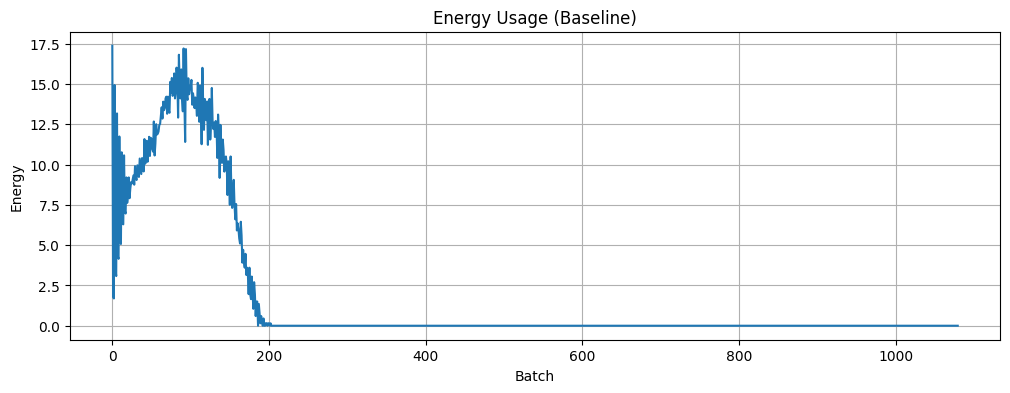

In [5]:

plt.figure(figsize=(12, 4))
plt.plot(energy_usage)
plt.title("Energy Usage (Baseline)")
plt.xlabel("Batch")
plt.ylabel("Energy")
plt.grid(True)
plt.show()

### ARR Retained
Aggregate retained value across surviving users.


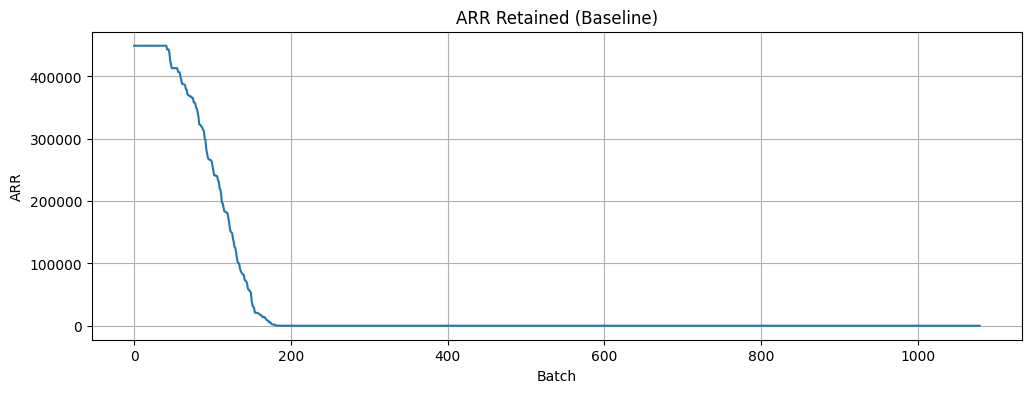

In [6]:

plt.figure(figsize=(12, 4))
plt.plot(arr_retained)
plt.title("ARR Retained (Baseline)")
plt.xlabel("Batch")
plt.ylabel("ARR")
plt.grid(True)
plt.show()


### Final Archetype Survival
Which user types remained active by the end of the simulation.
This reveals which behavioral profiles were most vulnerable to churn.


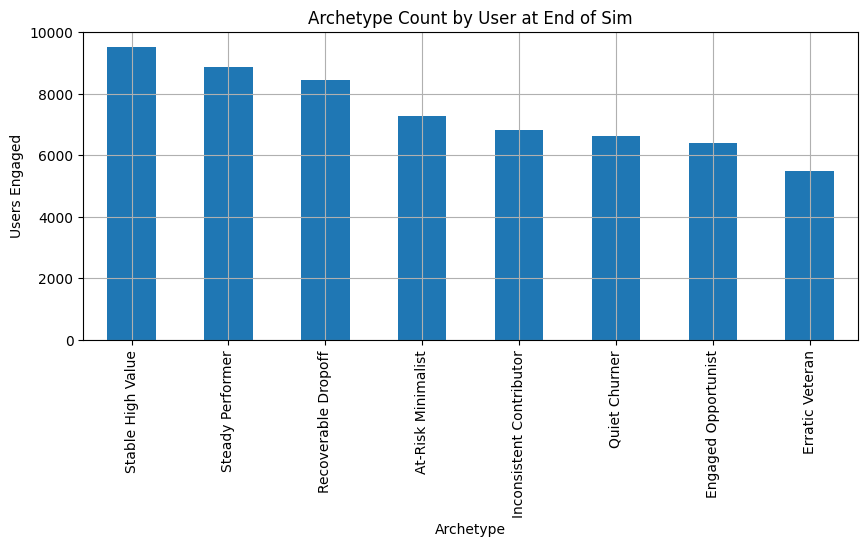

In [ ]:

arch_df = pd.DataFrame.from_dict(archetype_tracker, orient='index', columns=["count"]).sort_values("count", ascending=False)
arch_df.plot(kind="bar", legend=False, title="Total Engaged Users by Archetype (Cumulative)", figsize=(10,4))
plt.xlabel("Archetype")
plt.ylabel("Users Engaged")
plt.grid(True)
plt.show()


# Copyright 2025 Divine Comedy Labs LLC
# Released under the Polyform Noncommercial License 1.0.0
